# Prepare toy example data-set for M&M ASH model
Here I take a gene from 2 tissues, with covariates. 

The genotypes matrix should have complete data after imputation. However not all samples overlap in both tissues, making expression matrix. For the time being I'll make 2 versions: one version with missing expression matrix as is, the other version fills in the missing data using mean imputation (use mean for expression in the tissue in question).

The 2 tissues of choice are lung and thyroid (i do not trust whole blood).

The gene I take is FMO2 (ENSG00000094963 on chr1). Separate data-sets for Lung and Thyroid are extracted using [this notebook](20171017_Extract_Full_Tissue_Data.html). The data are:

```
~/Documents/GTExV8/Thyroid.FMO2.pm1Mb.RDS
~/Documents/GTExV8/Lung.FMO2.pm1Mb.RDS
```

Also I remove covariates beforhand -- it is difficult to consider covariates for multiple Y because each Y may have a different set of covariates. Removing them beforehand might be the only way to go.

## Data exploration

In [ ]:
dat1 = readRDS('~/Documents/GTExV8/Thyroid.FMO2.pm1Mb.RDS')
dat2 = readRDS('~/Documents/GTExV8/Lung.FMO2.pm1Mb.RDS')

In [2]:
str(dat1$X)

 num [1:574, 1:7492] 1 0 0 0 0 1 1 0 1 1 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:574] "GTEX-111CU" "GTEX-111FC" "GTEX-111VG" "GTEX-111YS" ...
  ..$ : chr [1:7492] "chr1_170185243_G_A_b38" "chr1_170185272_T_C_b38" "chr1_170185405_C_A_b38" "chr1_170185417_G_A_b38" ...


In [3]:
str(dat2$X)

 num [1:515, 1:7492] 1 0 0 0 0 1 1 1 1 0 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:515] "GTEX-111CU" "GTEX-111FC" "GTEX-111VG" "GTEX-111YS" ...
  ..$ : chr [1:7492] "chr1_170185243_G_A_b38" "chr1_170185272_T_C_b38" "chr1_170185405_C_A_b38" "chr1_170185417_G_A_b38" ...


In [4]:
str(dat1$y)
str(dat2$y)

 num [1:574] -0.177 -0.372 0.463 0.34 -0.829 ...
 num [1:515] -1.522 1.789 -0.394 0.999 -0.151 ...


In [5]:
str(dat1$Z)
str(dat2$Z)

 num [1:574, 1:68] 0.0107 0.0099 0.0144 0.0154 0.0139 0.0145 0.0106 0.0139 0.0109 -0.024 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:574] "GTEX-111CU" "GTEX-111FC" "GTEX-111VG" "GTEX-111YS" ...
  ..$ : chr [1:68] "PC1" "PC2" "PC3" "PC4" ...
 num [1:515, 1:68] 0.0107 0.0099 0.0144 0.0154 0.0139 0.0145 0.0109 -0.024 0.0141 -0.0898 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:515] "GTEX-111CU" "GTEX-111FC" "GTEX-111VG" "GTEX-111YS" ...
  ..$ : chr [1:68] "PC1" "PC2" "PC3" "PC4" ...


In [6]:
all_samples = union(rownames(dat1$X), rownames(dat2$X))
print(length(all_samples))

[1] 698


## Removing covariates


In [7]:
dat1$y = .lm.fit(dat1$Z, dat1$y)$residuals
dat2$y = .lm.fit(dat2$Z, dat2$y)$residuals

## Data merger
### y

In [8]:
y1 = data.frame(matrix(dat1$y, length(dat1$y), 1))
y2 = data.frame(matrix(dat2$y, length(dat2$y), 1))
rownames(y1) = rownames(dat1$X)
rownames(y2) = rownames(dat2$X)
colnames(y1) = 'Thyroid'
colnames(y2) = 'Lung'
y1$rows = rownames(y1)
y2$rows = rownames(y2)

In [9]:
y <-merge(y1,y2, by='rows', all=T)
rownames(y) = y$rows
y = y[order(rownames(y)),-1]

In [10]:
head(y)

,Thyroid,Lung
GTEX-111CU,0.1634810,0.770109170
GTEX-111FC,0.4358900,0.777987356
GTEX-111VG,-0.2123731,-0.653611927
GTEX-111YS,0.3266490,0.006720028
GTEX-1122O,-0.6978312,-0.367917802
GTEX-1128S,0.8401226,-0.097376461


In [11]:
sum(is.na(y))

[1] 307

### X

In [12]:
X2 = subset(dat2$X, !(rownames(dat2$X) %in% rownames(dat1$X)))
X = rbind(dat1$X, X2)
X = X[order(rownames(X)),]

In [13]:
dim(X)

[1]  698 7492

## Save data: with missing / without missing

In [14]:
y_filled = y
for(i in 1:ncol(y)){
  y_filled[is.na(y[,i]), i] <- mean(y[,i], na.rm = TRUE)
}
saveRDS(list(Y=y_filled,X=X), '~/Documents/GTExV8/Thyroid.Lung.FMO2.filled.rds')
saveRDS(list(Y=y,X=X), '~/Documents/GTExV8/Thyroid.Lung.FMO2.rds')

## Analyze per-tissue data with mr-ash

In [15]:
autoselect.mixsd = function(betahat,sebetahat,mult = sqrt(2)){
    # To avoid exact measure causing (usually by mistake)
    sebetahat = sebetahat[sebetahat!=0] 
    # so that the minimum is small compared with measurement precision
    sigmaamin = min(sebetahat)/10 
    if (all(betahat^2 <= sebetahat^2)) {
        # to deal with the occassional odd case where this could happen; 8 is arbitrary
        sigmaamax = 8*sigmaamin 
    } else {
        # this computes a rough largest value you'd want to use, 
        # based on idea that sigmaamax^2 + sebetahat^2 should be at least betahat^2   
        sigmaamax = 2*sqrt(max(betahat^2-sebetahat^2)) 
    }
    if(mult==0){
        return(c(0,sigmaamax/2))
    } else {
        npoint = ceiling(log2(sigmaamax/sigmaamin)/log2(mult))
        return(mult^((-npoint):0) * sigmaamax)
    }
}

univariate_regression = function(X, y, Z = NULL){
    if (!is.null(Z)) {
        y = .lm.fit(Z, y)$residuals
    }
    calc_stderr = function(X, residuals) { sqrt(diag(sum(residuals^2) / (nrow(X) - 2) * chol2inv(chol(t(X) %*% X)))) }
    output = do.call(rbind, 
                  lapply(c(1:ncol(X)), function(i) { 
                      g = .lm.fit(cbind(1, X[,i]), y)
                      return(c(coef(g)[2], calc_stderr(cbind(1, X[,i]), g$residuals)[2]))
                  })
                 )
    return(list(betahat = output[,1], sebetahat = output[,2], 
                residuals = y))
}

lasso_reorder = function(X, y) {
    # perform lasso regression and reorder regressors by "importance"
    fit.glmnet <- glmnet::glmnet(X, y, intercept = F)
    beta_path = coef(fit.glmnet)[-1,]
    K = dim(beta_path)[2]
    path_order = c()
    for (k in 1:K) {
        crt_path = which(beta_path[,k] != 0)
        if (length(crt_path) != 0 & length(path_order) == 0) {
            path_order = c(path_order, crt_path)
        } else if(length(crt_path) != 0) {
            path_order = c(path_order, crt_path[-which(crt_path %in% path_order)] )
        }
    }
    path_order = unname(path_order)
    index_order = c(path_order, seq(1,dim(beta_path)[1])[-path_order])
    return(index_order)
}

X = X[,which(colSums(X)!=0)]

## For thyroid

In [16]:
initial = univariate_regression(X, y_filled$Thyroid)
mixsd = autoselect.mixsd(initial$betahat, initial$sebetahat)
mu_zero = matrix(0, ncol = length(mixsd)+1, nrow = ncol(X))
alpha_zero = matrix(1/ncol(X), ncol = length(mixsd)+1,nrow = ncol(X))
alpha_zero[,1] = 1 - length(mixsd) / ncol(X)
index_order = lasso_reorder(X, initial$residuals)
logdata = capture.output({ fit = varbvs::varbvsmix(X[, index_order], NULL, y_filled$Thyroid, 
                                                  sa = c(0,mixsd^2), 
                                                  mu = mu_zero,
                                                  alpha = alpha_zero,
                                                  verbose = F) })
betahat = rowSums(fit$alpha * fit$mu)
names(betahat) = colnames(X)
mr_ash_out = list(betahat = betahat, fit = fit)

In [17]:
sort(fit$lfsr)[1:10]

chr1_171133158_A_G_b38 chr1_171172098_C_T_b38 chr1_171174538_G_C_b38 
          1.747387e-06           1.967048e-06           6.103813e-01 
chr1_171178705_A_G_b38 chr1_171164750_C_A_b38 chr1_171252314_G_C_b38 
          6.107516e-01           6.107539e-01           6.121650e-01 
chr1_171190872_G_A_b38 chr1_171251097_G_T_b38 chr1_171219393_T_A_b38 
          6.172342e-01           6.191240e-01           6.198333e-01 
chr1_171241888_C_G_b38 
          6.213152e-01

In [18]:
sort(betahat, decreasing = T)[1:10]

chr1_170185243_G_A_b38  chr1_170189678_C_G_b38 chr1_170760676_C_CT_b38 
            0.193936191             0.006824834             0.004438705 
 chr1_170189560_T_C_b38  chr1_170236154_G_A_b38  chr1_170188051_G_A_b38 
            0.004204999             0.003150198             0.003113900 
 chr1_170187993_G_A_b38  chr1_171374013_T_G_b38  chr1_171351456_G_A_b38 
            0.003113875             0.002967973             0.002301111 
chr1_171348122_CT_C_b38 
            0.001542861

In [19]:
lasso_res = glmnet::glmnet(X, y_filled$Thyroid, intercept = F)

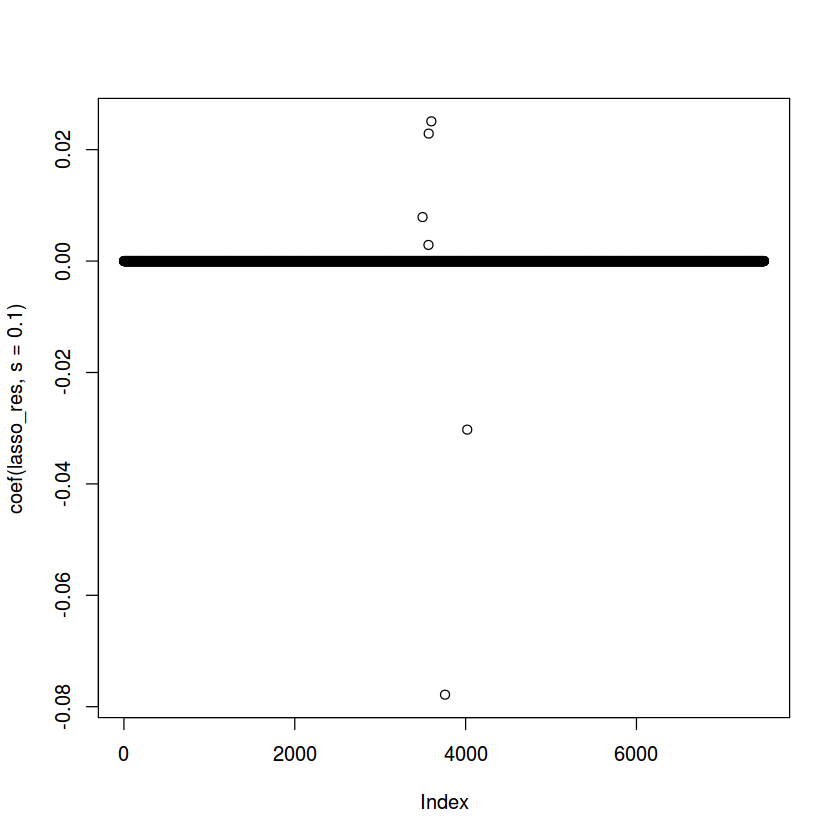

In [20]:
plot(coef(lasso_res, s = 0.1))

## For Lung

In [22]:
initial = univariate_regression(X, y_filled$Lung)
mixsd = autoselect.mixsd(initial$betahat, initial$sebetahat)
mu_zero = matrix(0, ncol = length(mixsd)+1, nrow = ncol(X))
alpha_zero = matrix(1/ncol(X), ncol = length(mixsd)+1,nrow = ncol(X))
alpha_zero[,1] = 1 - length(mixsd) / ncol(X)
index_order = lasso_reorder(X, initial$residuals)
logdata = capture.output({ fit = varbvs::varbvsmix(X[, index_order], NULL, y_filled$Thyroid, 
                                                  sa = c(0,mixsd^2), 
                                                  mu = mu_zero,
                                                  alpha = alpha_zero,
                                                  verbose = F) })
betahat = rowSums(fit$alpha * fit$mu)
names(betahat) = colnames(X)
mr_ash_out = list(betahat = betahat, fit = fit)

In [23]:
sort(fit$lfsr)[1:10]

chr1_171172098_C_T_b38  chr1_171122735_A_G_b38  chr1_171147265_C_A_b38 
           2.604126e-08            4.665324e-01            4.723315e-01 
 chr1_171143351_C_T_b38  chr1_171140916_T_C_b38 chr1_171119633_A_AC_b38 
           4.765733e-01            4.784856e-01            4.884060e-01 
 chr1_171142226_G_T_b38  chr1_171150061_G_C_b38  chr1_171139697_C_T_b38 
           4.887907e-01            4.945153e-01            4.952655e-01 
 chr1_171134913_G_A_b38 
           4.955787e-01

In [24]:
sort(betahat, decreasing = T)[1:10]

chr1_170661923_CT_C_b38  chr1_170732193_T_C_b38  chr1_171223445_G_C_b38 
            0.007083466             0.004146607             0.003870002 
 chr1_171239025_A_G_b38  chr1_171237397_A_G_b38  chr1_171235824_G_A_b38 
            0.003033014             0.002611515             0.002317159 
 chr1_171231230_T_C_b38  chr1_171235455_T_G_b38  chr1_171229029_C_T_b38 
            0.002175368             0.002163583             0.002129715 
 chr1_171228944_C_T_b38 
            0.002129660

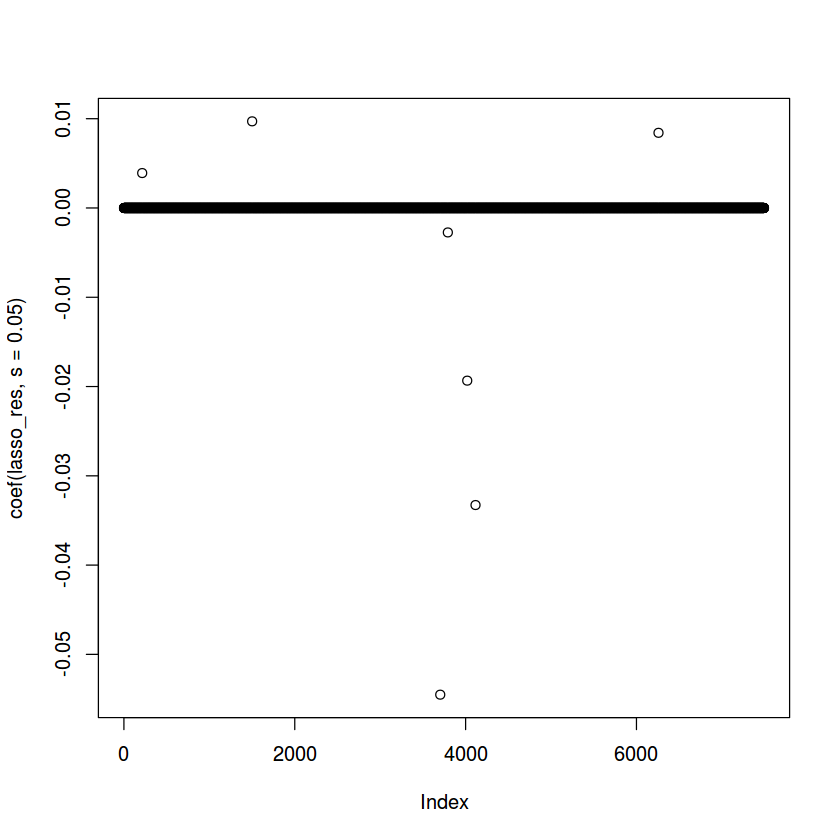

In [28]:
lasso_res = glmnet::glmnet(X, y_filled$Lung, intercept = F)
plot(coef(lasso_res, s = 0.05))